In [77]:
# elimino todas las variables excepto loan_data2
rm(list = setdiff(ls(), "loan_data2"))

In [41]:
# importacion de librerias
library(readr)
library(caret)
library(ggplot2)
library(dplyr)
library(vcd)
library(reshape2)
library(ltm)
library(gmodels)
library(pROC)
library(kknn)
library(e1071)
library(rsample)
library(naivebayes)

In [42]:
loan_data2 <- read_csv("Anonymize_Loan_Default_data_ML2.csv")
loan_data2 <- as.data.frame(loan_data2)

Rows: 38345 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): term, last_pymnt_d, last_credit_pull_d
dbl (18): loan_amnt, funded_amnt, funded_amnt_inv, int_rate, installment, an...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


La siguiente celda tiene como objetivo calcular la correlación biserial entre las variables numéricas de un conjunto de datos y la variable de interés (repay_fail), y luego visualizar estas correlaciones utilizando un heatmap.

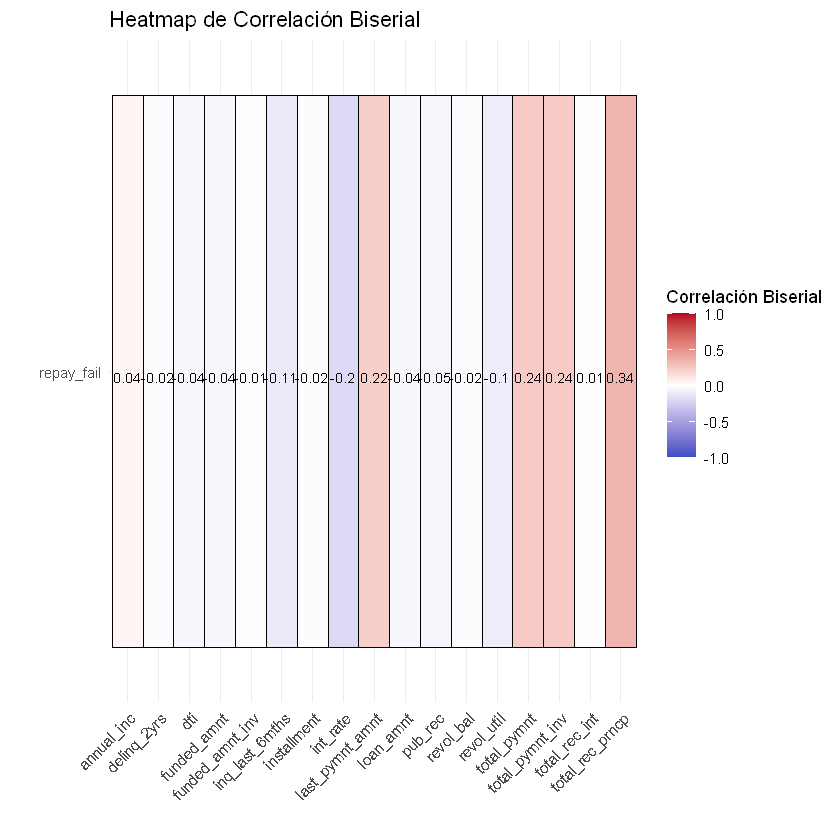

In [43]:
# Selecciono solo las columnas numéricas
numeric_vars <- sapply(loan_data2, is.numeric)
datos_numericos <- loan_data2[, numeric_vars]

# Añado 'repay_fail' a los datos numéricos
datos_numericos$repay_fail <- loan_data2$repay_fail

# Función para calcular la correlación biserial
cor_biserial <- function(x, y) {
  biserial.cor(x, y)
}

# Calculo la correlación biserial entre cada variable numérica y 'repay_fail'
correlaciones <- sapply(datos_numericos[,
                                        -ncol(datos_numericos)],
                        cor_biserial, y = datos_numericos$repay_fail)

# Convierto las correlaciones a un data frame para ggplot
correlaciones_df <- data.frame(Variable = names(correlaciones),
                               Correlacion = correlaciones)

# Ajusto tamaño de etiquetas para mejorar la visualización
correlaciones_df$Correlacion <- round(correlaciones_df$Correlacion, 2)

# Creo el heatmap con etiquetas mejoradas
ggplot(correlaciones_df, aes(x = Variable, y = "repay_fail",
                             fill = Correlacion)) +
  geom_tile(color = "black") +
  geom_text(aes(label = Correlacion), vjust = 1, color = "black", size = 3) +
  scale_fill_gradient2(low = "#3B4CC0", mid = "#FFFFFF", high = "#B40426",
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name = "Correlación Biserial") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "", y = "", title = "Heatmap de Correlación Biserial")

Propósito y Utilidad

El propósito del código es identificar qué variables numéricas tienen una relación significativa con la variable repay_fail. Esta información es crucial para:

Selección de Características:

Identificar las variables más relevantes para incluir en el modelo de Naive Bayes.

Preprocesamiento:

Determinar qué variables podrían necesitar transformaciones adicionales (como binning) antes de ser utilizadas en el modelo.

La siguiente celda se encarga de eliminar las variables que tienen una baja correlación con la variable objetivo repay_fail.

In [44]:
#por ende procedo a eliminar las variables que tienen baja
# correlación con la variable objetivo
#osea elimino funded_amnt_inv, installment, revol_bal, total_rec_int
# delinq_2yrs, funded_amnt, pub_rec, inq_last_6mths, loan_amnt, revol_util
loan_data2 <- loan_data2 %>%
  dplyr::select(-funded_amnt_inv, -installment, -revol_bal,
                -total_rec_int, -delinq_2yrs, -funded_amnt, -pub_rec,
                -inq_last_6mths, -loan_amnt, -revol_util)

Este paso se enfoca en eliminar variables que no aportan información significativa en relación con la variable objetivo repay_fail. Reducir el número de variables simplifica el modelo y mejora su rendimiento, evitando el sobreajuste.

Mejora en la Eficiencia del Modelo:

Al eliminar las variables irrelevantes, el modelo de Naive Bayes podrá centrarse en las variables que realmente tienen una influencia significativa en la predicción de repay_fail.

In [45]:
head(loan_data2)

,term,int_rate,annual_inc,dti,total_pymnt,total_pymnt_inv,total_rec_prncp,last_pymnt_amnt,repay_fail,last_pymnt_d,last_credit_pull_d
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,36 months,13.98,20004,19.86,3075.292,3075.29,2500.00,90.85,0,2011-2013,2014-2016
2,36 months,15.95,59000,19.57,2948.760,2948.76,1909.02,175.67,1,2011-2013,2011-2013
3,36 months,9.91,53796,10.80,8082.392,8082.39,7000.00,1550.27,0,2014-2016,2014-2016
4,36 months,5.42,30000,3.60,2161.663,2161.66,2000.00,53.12,0,2014-2016,2014-2016
5,36 months,10.25,675048,1.55,4206.031,4206.03,3600.00,146.75,0,2011-2013,2014-2016
6,36 months,6.03,77736,6.07,8724.972,8724.97,8000.00,1423.66,0,2014-2016,2014-2016


En el preprocesamiento de datos, especialmente cuando se trabaja con modelos de machine learning como naive bayes que no pueden manejar variables categóricas directamente, se convierten estas variables en variables dummy. Este proceso implica crear nuevas columnas binarias para representar las categorías originales de la variable. 

En el contexto de Naive Bayes para clasificación, la creación de variables dummy sigue el principio de n - 1 columnas por razones específicas a cómo este algoritmo maneja las variables categóricas.

Razón para n - 1 Columnas Dummy en Naive Bayes

Evitar la Multicolinealidad:

Aunque Naive Bayes no se ve afectado por la multicolinealidad de la misma manera que otros modelos lineales (como la regresión lineal o logística), crear n columnas para n categorías introduce redundancia innecesaria. Esto puede llevar a cálculos innecesarios y complicaciones en la interpretación.

Simplicidad y Eficiencia Computacional:

Naive Bayes asume que las características son independientes unas de otras (suposición de independencia condicional). Para mantener este supuesto de manera eficiente, se crean n - 1 columnas dummy. Esto simplifica los cálculos de probabilidad y evita el sobreajuste, ya que la redundancia puede hacer que el modelo se ajuste demasiado a los datos de entrenamiento.

Categoría de Referencia:

Al crear n - 1 dummies, una categoría se toma como referencia implícita. Esta referencia no necesita ser representada explícitamente porque su información está contenida en las otras variables dummy. En términos de Naive Bayes, esto significa que la probabilidad de la categoría de referencia se puede calcular implícitamente cuando todas las otras dummies son 0.

In [46]:
#tratamiento de variable categórica term
table(loan_data2$term) # 2 levels (1 dummy)
loan_data2$term_60_months <- ifelse(loan_data2$term == "60 months", 1, 0)
loan_data2$term <- ifelse(loan_data2$term == "36 months", 1, 0)
table(loan_data2$term_60_months) ; table(loan_data2$term)


36 months 60 months 
    28478      9867 


    0     1 
28478  9867 


    0     1 
 9867 28478 

En este caso:

term_60_months = 1 si el término es "60 months", 0 en caso contrario.
term = 1 si el término es "36 months", 0 en caso contrario.
Aquí, una de las categorías (term para "36 months") actúa como la categoría de referencia implícita. 

Para Naive Bayes:

Probabilidades Condicionales:

Naive Bayes calculará las probabilidades condicionales de cada categoría de la variable objetivo dado cada variable dummy.
Por ejemplo, calculará P(repay_fail | term_60_months = 1) y P(repay_fail | term = 1).

Independencia Condicional:

Asumiendo independencia condicional, Naive Bayes combinará estas probabilidades para predecir la categoría de la variable objetivo. La eliminación de una dummy asegura que no haya redundancia en estas combinaciones.

Cálculo de Probabilidades:

La categoría de referencia ("36 months" en este caso) no necesita una columna dummy explícita. Su probabilidad se deduce cuando term_60_months = 0. Naive Bayes utiliza esta información para calcular P(repay_fail | term = 1) implícitamente.

Para las otras columnas categoricas se aplicará lo mismo

In [47]:
# last_pymnt_d
table(loan_data2$last_pymnt_d) # 3 levels (2 dummies)
loan_data2$last_pymnt_d_2011_2013 <- ifelse(loan_data2$last_pymnt_d ==
                                           "2011-2013", 1, 0)
loan_data2$last_pymnt_d_2014_2016 <- ifelse(loan_data2$last_pymnt_d ==
                                           "2014-2016", 1, 0)
loan_data2$last_pymnt_d <- ifelse(loan_data2$last_pymnt_d ==
                                 "2007-2010", 1, 0)
table(loan_data2$last_pymnt_d_2011_2013)
table(loan_data2$last_pymnt_d_2014_2016)
table(loan_data2$last_pymnt_d)


2007-2010 2011-2013 2014-2016 
     3222     22539     12584 


    0     1 
15806 22539 


    0     1 
25761 12584 


    0     1 
35123  3222 

In [48]:
# last_credit_pull_d
table(loan_data2$last_credit_pull_d) # 3 levels (2 dummies)
loan_data2$last_credit_pull_d_2011_2013 <- ifelse(loan_data2$last_credit_pull_d ==
                                                   "2011-2013", 1, 0)
loan_data2$last_credit_pull_d_2014_2016 <- ifelse(loan_data2$last_credit_pull_d ==
                                                   "2014-2016", 1, 0)
loan_data2$last_credit_pull_d <- ifelse(loan_data2$last_credit_pull_d ==
                                         "2007-2010", 1, 0)
table(loan_data2$last_credit_pull_d_2011_2013)
table(loan_data2$last_credit_pull_d_2014_2016)
table(loan_data2$last_credit_pull_d)


2007-2010 2011-2013 2014-2016 
     1431     11041     25873 


    0     1 
27304 11041 


    0     1 
12472 25873 


    0     1 
36914  1431 

Tratamiento variables numericas (Binning)

En el contexto de Naive Bayes para clasificación, las variables numéricas se convierten en categóricas mediante un proceso llamado binning. Este proceso divide el rango de valores de una variable numérica en varios intervalos discretos, transformándolos en variables categóricas que el algoritmo puede manejar eficientemente. 

In [49]:
#Variable numerica int_rate

# int_rate
#Min. : 5.42
#1st Qu.: 9.62
#Median :11.99
#Mean :12.15
#3rd Qu.:14.72
#Max. :24.11

loan_data2$int_rate_low <- ifelse(loan_data2$int_rate < 9.62, 1, 0)
loan_data2$int_rate_mid_low <- ifelse(loan_data2$int_rate >= 9.62 &
                                       loan_data2$int_rate < 11.99, 1, 0)
loan_data2$int_rate_mid_high <- ifelse(loan_data2$int_rate >= 11.99 &
                                        loan_data2$int_rate < 14.72, 1, 0)
loan_data2$int_rate_high <- ifelse(loan_data2$int_rate >= 14.72, 1, 0)
table(loan_data2$int_rate_low)
table(loan_data2$int_rate_mid_low)
table(loan_data2$int_rate_mid_high)
table(loan_data2$int_rate_high)


    0     1 
28901  9444 


    0     1 
28829  9516 


    0     1 
28580  9765 


    0     1 
28725  9620 

Transformación de Variables Numéricas en Categóricas:

El algoritmo Naive Bayes requiere variables 0 y 1 para funcionar correctamente. El binning convierte una variable numérica (int_rate en este caso) en varias variables binarias categóricas.

Simplificación y Interpretación

Dividir una variable numérica en intervalos discretos puede simplificar el modelo y mejorar la interpretación, ya que los intervalos pueden representar categorías significativas (por ejemplo, tasas de interés bajas, medias y altas).

Detalles del Binning

Definición de Intervalos

Los intervalos se definen basándose en los percentiles (cuartiles) de la distribución de la variable `int_rate`:

- `int_rate_low`: Tasa de interés menor a 9.62 (primer cuartil).
- `int_rate_mid_low`: Tasa de interés entre 9.62 y 11.99 (primer cuartil a la mediana).
- `int_rate_mid_high`: Tasa de interés entre 11.99 y 14.72 (mediana al tercer cuartil).
- `int_rate_high`: Tasa de interés mayor o igual a 14.72 (tercer cuartil).

Creación de Variables Binarias:

Cada intervalo se convierte en una variable binaria:

- `int_rate_low`: Toma el valor 1 si int_rate es menor a 9.62, y 0 en caso contrario.
- `int_rate_mid_low`: Toma el valor 1 si int_rate está entre 9.62 y 11.99, y 0 en caso contrario.
- `int_rate_mid_high`: Toma el valor 1 si int_rate está entre 11.99 y 14.72, y 0 en caso contrario.
- `int_rate_high`: Toma el valor 1 si int_rate es mayor o igual a 14.72, y 0 en caso contrario.

Impacto en el Proceso de Naive Bayes

Adaptación del Algoritmo:

Al convertir int_rate en variables categóricas, Naive Bayes puede manejar estas características de manera eficiente, calculando las probabilidades condicionales de cada categoría respecto a la variable objetivo repay_fail.

Mantenimiento del Supuesto de Independencia:

El supuesto de independencia condicional en Naive Bayes se mantiene más fácilmente con variables binarias, simplificando el cálculo de las probabilidades conjuntas.

Para las siguientes variables numericas se realizó el mismo proceso, pero con sus respectivos cuartiles.

In [50]:
# variable numerica annual_inc

#Min.   :   1896
#1st Qu.:  40000
#Median :  58880
#Mean   :  69058
#3rd Qu.:  82100
#Max.   :6000000

loan_data2$annual_inc_high <- ifelse(loan_data2$annual_inc > 82100, 1, 0)
loan_data2$annual_inc_low <- ifelse(loan_data2$annual_inc < 40000, 1, 0)
loan_data2$annual_inc_mid_low <- ifelse(loan_data2$annual_inc >= 40000 &
                                         loan_data2$annual_inc < 58880, 1, 0)
loan_data2$annual_inc_mid_high <- ifelse(loan_data2$annual_inc >= 58880 &
                                          loan_data2$annual_inc <= 82100, 1, 0)
table(loan_data2$annual_inc_high)
table(loan_data2$annual_inc_low)
table(loan_data2$annual_inc_mid_low)
table(loan_data2$annual_inc_mid_high)


    0     1 
28759  9586 


    0     1 
29575  8770 


    0     1 
27943 10402 


    0     1 
28758  9587 

Para la variable numérica "annual_inc", considerando los valores, hice los binning de la siguiente manera:

- Menor que el primer cuartil (40,000)
- Entre el primer cuartil y la mediana (40,000 - 58,880)
- Entre la mediana y el tercer cuartil (58,880 - 82,100)
- Mayor que el tercer cuartil (82,100)

In [51]:
# variable numerica dti

#Min.   : 0.00
#1st Qu.: 8.21
#Median :13.49
#Mean   :13.38
#3rd Qu.:18.69
#Max.   :29.99

loan_data2$dti_high <- ifelse(loan_data2$dti > 18.69, 1, 0)
loan_data2$dti_low <- ifelse(loan_data2$dti < 8.21, 1, 0)
loan_data2$dti_mid_low <- ifelse(loan_data2$dti >= 8.21 &
                                  loan_data2$dti < 13.49, 1, 0)
loan_data2$dti_mid_high <- ifelse(loan_data2$dti >= 13.49 &
                                   loan_data2$dti <= 18.69, 1, 0)
table(loan_data2$dti_high)
table(loan_data2$dti_low)
table(loan_data2$dti_mid_low)
table(loan_data2$dti_mid_high)


    0     1 
28764  9581 


    0     1 
28768  9577 


    0     1 
28762  9583 


    0     1 
28741  9604 

Para la variable numérica "dti", considerando los valores, hice los binning de la siguiente manera:

- Menor que el primer cuartil (8.21)
- Entre el primer cuartil y la mediana (8.21 - 13.49)
- Entre la mediana y el tercer cuartil (13.49 - 18.69)
- Mayor que el tercer cuartil (18.69)

In [52]:
# variable numerica total_pymnt

#Min.   :   35.71
#1st Qu.: 5487.53
#Median : 9708.77
#Mean   :12012.95
#3rd Qu.:16427.20
#Max.   :58563.68

loan_data2$total_pymnt_high <- ifelse(loan_data2$total_pymnt > 16427.20, 1, 0)
loan_data2$total_pymnt_low <- ifelse(loan_data2$total_pymnt < 5487.53, 1, 0)
loan_data2$total_pymnt_mid_low <- ifelse(loan_data2$total_pymnt >= 5487.53 &
                                          loan_data2$total_pymnt < 9708.77, 1, 0)
loan_data2$total_pymnt_mid_high <- ifelse(loan_data2$total_pymnt >= 9708.77 &
                                           loan_data2$total_pymnt
                                           <= 16427.20, 1, 0)
table(loan_data2$total_pymnt_high)
table(loan_data2$total_pymnt_low)
table(loan_data2$total_pymnt_mid_low)
table(loan_data2$total_pymnt_mid_high)


    0     1 
28759  9586 


    0     1 
28759  9586 


    0     1 
28758  9587 


    0     1 
28759  9586 

Para la variable numérica "total_pymnt", considerando los valores, hice los binning de la siguiente manera:

- Menor que el primer cuartil (5487.53)
- Entre el primer cuartil y la mediana (5487.53 - 9708.77)
- Entre la mediana y el tercer cuartil (9708.77 - 16427.20)
- Mayor que el tercer cuartil (16427.20)

In [53]:
# variable numerica total_pymnt_inv

#Min.   :    0
#1st Qu.: 4851
#Median : 8981
#Mean   :11307
#3rd Qu.:15517
#Max.   :58564

loan_data2$total_pymnt_inv_high <- ifelse(loan_data2$total_pymnt_inv >
                                           15517, 1, 0)
loan_data2$total_pymnt_inv_low <- ifelse(loan_data2$total_pymnt_inv < 4851, 1, 0)
loan_data2$total_pymnt_inv_mid_low <- ifelse(loan_data2$total_pymnt_inv >= 4851 &
                                              loan_data2$total_pymnt_inv <
                                                8981, 1, 0)
loan_data2$total_pymnt_inv_mid_high <- ifelse(loan_data2$total_pymnt_inv >= 8981 &
                                               loan_data2$total_pymnt_inv <=
                                                 15517, 1, 0)
table(loan_data2$total_pymnt_inv_high)
table(loan_data2$total_pymnt_inv_low)
table(loan_data2$total_pymnt_inv_mid_low)
table(loan_data2$total_pymnt_inv_mid_high)


    0     1 
28760  9585 


    0     1 
28761  9584 


    0     1 
28757  9588 


    0     1 
28757  9588 

Para la variable numérica "total_pymnt_inv", considerando los valores, hice binning de la siguiente manera:

- Menor que el primer cuartil (4851)
- Entre el primer cuartil y la mediana (4851 - 8981)
- Entre la mediana y el tercer cuartil (8981 - 15517)
- Mayor que el tercer cuartil (15517)

In [54]:
# variable numerica total_rec_prncp

#Min.   :    0
#1st Qu.: 4485
#Median : 8000
#Mean   : 9673
#3rd Qu.:13450
#Max.   :35000

loan_data2$total_rec_prncp_high <- ifelse(loan_data2$total_rec_prncp >
                                           13450, 1, 0)
loan_data2$total_rec_prncp_low <- ifelse(loan_data2$total_rec_prncp < 4485, 1, 0)
loan_data2$total_rec_prncp_mid_low <- ifelse(loan_data2$total_rec_prncp >= 4485 &
                                              loan_data2$total_rec_prncp <
                                                8000, 1, 0)
loan_data2$total_rec_prncp_mid_high <- ifelse(loan_data2$total_rec_prncp >= 8000 &
                                               loan_data2$total_rec_prncp <=
                                                 13450, 1, 0)
table(loan_data2$total_rec_prncp_high)
table(loan_data2$total_rec_prncp_low)
table(loan_data2$total_rec_prncp_mid_low)
table(loan_data2$total_rec_prncp_mid_high)


    0     1 
28763  9582 


    0     1 
28758  9587 


    0     1 
29408  8937 


    0     1 
28106 10239 


Para la variable numérica "total_rec_prncp", considerando los valores, hice binning de la siguiente manera:

- Menor que el primer cuartil (4485)
- Entre el primer cuartil y la mediana (4485 - 8000)
- Entre la mediana y el tercer cuartil (8000 - 13450)
- Mayor que el tercer cuartil (13450)

In [55]:
# variable numerica last_pymnt_amnt

#Min.   :    0.0
#1st Qu.:  213.8
#Median :  528.5
#Mean   : 2622.5
#3rd Qu.: 3184.3
#Max.   :36115.2

loan_data2$last_pymnt_amnt_high <- ifelse(loan_data2$last_pymnt_amnt >
                                           3184.3, 1, 0)
loan_data2$last_pymnt_amnt_low <- ifelse(loan_data2$last_pymnt_amnt < 213.8, 1, 0)
loan_data2$last_pymnt_amnt_mid_low <- ifelse(loan_data2$last_pymnt_amnt >=
                                              213.8 &
                                              loan_data2$last_pymnt_amnt <
                                                528.5, 1, 0)
loan_data2$last_pymnt_amnt_mid_high <- ifelse(loan_data2$last_pymnt_amnt >=
                                               528.5 &
                                               loan_data2$last_pymnt_amnt <=
                                                 3184.3, 1, 0)
table(loan_data2$last_pymnt_amnt_high)
table(loan_data2$last_pymnt_amnt_low)
table(loan_data2$last_pymnt_amnt_mid_low)
table(loan_data2$last_pymnt_amnt_mid_high)


    0     1 
28759  9586 


    0     1 
28758  9587 


    0     1 
28760  9585 


    0     1 
28758  9587 

Para la variable numérica "last_pymnt_amnt", considerando los valores, hice binning de la siguiente manera:

- Menor que el primer cuartil (213.8)
- Entre el primer cuartil y la mediana (213.8 - 528.5)
- Entre la mediana y el tercer cuartil (528.5 - 3184.3)
- Mayor que el tercer cuartil (3184.3)

La siguiente celda elimina las columnas que ya fueron procesadas, de acuerdo a si son numericas y categoricas, eliminando su columna original no transformada.

In [56]:
loan_data2 <- loan_data2 %>%
  dplyr::select(-term, -last_pymnt_d, -last_credit_pull_d,
                -int_rate, -annual_inc, -dti, -total_pymnt,
                -total_pymnt_inv, -total_rec_prncp, -last_pymnt_amnt)
dim(loan_data2)
#nombre de las columnas de loan_data2
colnames(loan_data2)

[1] 38345    34

[1] "repay_fail"                   "term_60_months"              
 [3] "last_pymnt_d_2011_2013"       "last_pymnt_d_2014_2016"      
 [5] "last_credit_pull_d_2011_2013" "last_credit_pull_d_2014_2016"
 [7] "int_rate_low"                 "int_rate_mid_low"            
 [9] "int_rate_mid_high"            "int_rate_high"               
[11] "annual_inc_high"              "annual_inc_low"              
[13] "annual_inc_mid_low"           "annual_inc_mid_high"         
[15] "dti_high"                     "dti_low"                     
[17] "dti_mid_low"                  "dti_mid_high"                
[19] "total_pymnt_high"             "total_pymnt_low"             
[21] "total_pymnt_mid_low"          "total_pymnt_mid_high"        
[23] "total_pymnt_inv_high"         "total_pymnt_inv_low"         
[25] "total_pymnt_inv_mid_low"      "total_pymnt_inv_mid_high"    
[27] "total_rec_prncp_high"         "total_rec_prncp_low"         
[29] "total_rec_prncp_mid_low"      "total_rec_prncp_mid_high"    
[31] "last_pymnt_amnt_high"         "last_pymnt_amnt_low"         
[33] "last_pymnt_amnt_mid_low"      "last_pymnt_amnt_mid_high"

La siguiente celda asegura que la variable objetivo repay_fail esté en el formato adecuado para ser utilizada en el modelo Naive Bayes, que requiere que la variable de clase sea categórica (en este caso, un factor en R).

In [57]:
# repay_fail lo dejo como formato factor
table(loan_data2$repay_fail)
loan_data2$repay_fail <- as.factor(loan_data2$repay_fail)
prop.table(table(loan_data2$repay_fail))


    0     1 
32606  5739 


        0         1 
0.8503325 0.1496675 

En la siguiente celda se realiza la división del conjunto de datos en conjuntos de entrenamiento y prueba, asegurando que la distribución de la variable objetivo repay_fail se mantenga consistente en ambos conjuntos mediante estratificación. Se utiliza una semilla aleatoria para garantizar la reproducibilidad de los resultados.

In [58]:
### Splitting initial de los datos en conjunto de entrenamiento y prueba
set.seed(123) # Semilla
split <- initial_split(loan_data2, prop = 0.7, strata = "repay_fail")
loan_data_train <- training(split)
loan_data_test <- testing(split)

Por qué del 70%-30%

Suficiente Cantidad de Datos para Entrenamiento:

Usar el 70% de los datos para el entrenamiento asegura que el modelo tenga acceso a una cantidad suficiente de datos para aprender las características y patrones del conjunto de datos. Esto es esencial para construir un modelo robusto y reducir el riesgo de subajuste.

Evaluación Representativa:

Al reservar el 30% de los datos para el conjunto de prueba, se asegura una evaluación representativa del rendimiento del modelo. Este conjunto debe ser lo suficientemente grande para proporcionar una evaluación precisa y confiable del modelo en datos no vistos.

Prácticas Comunes:

La proporción de 70%-30% es una práctica común en machine learning, proporcionando un buen balance entre tener suficientes datos para el entrenamiento y una cantidad adecuada para la evaluación del modelo.

Subajuste y Sobreajuste

Subajuste

Definición: Ocurre cuando un modelo es demasiado simple para capturar la estructura subyacente de los datos. Un modelo con subajuste tendrá un rendimiento pobre tanto en el conjunto de entrenamiento como en el de prueba.

Prevención: Utilizar una proporción adecuada de datos de entrenamiento ayuda a mitigar el subajuste. Con el 70% de los datos para el entrenamiento, el modelo tiene suficiente información para aprender patrones complejos sin ser demasiado simple.

Sobreajuste

Definición: Ocurre cuando un modelo es demasiado complejo y se ajusta demasiado a los datos de entrenamiento, capturando también el ruido y las peculiaridades específicas de estos datos. Un modelo con sobreajuste tendrá un rendimiento excelente en el conjunto de entrenamiento pero pobre en el conjunto de prueba.

Prevención: Reservar el 30% de los datos para el conjunto de prueba permite evaluar cómo generaliza el modelo a datos nuevos. Si el modelo tiene un rendimiento significativamente peor en el conjunto de prueba comparado con el conjunto de entrenamiento, esto indica un posible sobreajuste.

Estratificación por repay_fail

Motivación: La estratificación por la variable objetivo repay_fail asegura que la distribución de las clases (yes y no) sea representativa en ambos conjuntos (entrenamiento y prueba). Esto es crucial para evitar sesgos y asegurar que el modelo sea evaluado de manera justa en una muestra que refleja la población original.

La proporción 70%-30% para la división del conjunto de datos se elige para equilibrar adecuadamente la cantidad de datos disponibles para el entrenamiento y la evaluación, ayudando a prevenir tanto el subajuste como el sobreajuste. La estratificación por repay_fail asegura que ambos conjuntos tengan distribuciones representativas, mejorando la robustez y la precisión de la evaluación del modelo.

El siguiente código verifica que la proporción de la variable objetivo repay_fail en los conjuntos de entrenamiento y prueba sea consistente, y luego genera vectores para la variable objetivo en ambos conjuntos.

In [ ]:
# Compruebo proporcion de "repay_fail"
round(prop.table(table(loan_data_train$repay_fail)), 2)
round(prop.table(table(loan_data_test$repay_fail)), 2)

# genero vectores de la variable objetivo
repay_fail_train <- loan_data_train$repay_fail
repay_fail_test <- loan_data_test$repay_fail

Verificación de la Proporción de repay_fail:

El uso de round(prop.table(table(...)), 2) permite comprobar que la distribución de la variable repay_fail es similar en los conjuntos de entrenamiento y prueba. Esto es importante para asegurar que ambos conjuntos sean representativos de la población original.

Los resultados 0.85 y 0.15 para ambas clases (0 y 1) indican que el 85% de las observaciones no tienen fallos de repago (0) y el 15% sí tienen fallos de repago (1), tanto en el conjunto de entrenamiento como en el de prueba.

Modelo Naive Bayes

1era forma: Paquete e1071, metodo naiveBayes que no permite configuracion de parametros (excepto sólo laplace ) y colocando hiperparametro suboptimo de forma manual, sin saber hiperparametro y parametros optimos que se obtendrian mediante remuestreo y grilla. 

1.1 Evaluacion del modelo, mediante metrica de accuracy, teniendo como output un vector de niveles

In [60]:
set.seed(12345)
nb_level <- naiveBayes(repay_fail ~ ., data = loan_data_train, laplace = 0)
nb_level <- predict(nb_level,
                    loan_data_test[colnames(loan_data_test) != "repay_fail"],
                    type = "class")

In [61]:
# Resultados
results <- confusionMatrix(nb_level, repay_fail_test)
results$table
results$overall[names(results$overall) == "Accuracy"]

          Reference
Prediction    0    1
         0 7536  410
         1 2246 1312

Accuracy 
0.7691238

Entrenamiento del Modelo Naive Bayes:

naiveBayes(repay_fail ~ ., data = loan_data_train, laplace = 0) entrena un modelo Naive Bayes utilizando el conjunto de datos de entrenamiento. El parámetro laplace = 0 indica que no se está aplicando suavizado de Laplace.

Predicción:

predict(nb_level, loan_data_test[colnames(loan_data_test) != "repay_fail"], type = "class") genera predicciones para el conjunto de prueba. El tipo de predicción class indica que se deben devolver las clases predichas.

Evaluación del Modelo:

confusionMatrix(nb_level, repay_fail_test) calcula la matriz de confusión y varias métricas de evaluación, incluyendo la precisión (accuracy).
results$overall[names(results$overall) == "Accuracy"] extrae el valor de precisión del resultado de la matriz de confusión.

Interpretación de los Resultados

Matriz de Confusión:

La matriz de confusión muestra la cantidad de verdaderos negativos, falsos negativos, verdaderos positivos y falsos positivos:

- 7536 verdaderos negativos (TN)
- 410 falsos negativos (FN)
- 2246 falsos positivos (FP)
- 1312 verdaderos positivos (TP)

Precisión (Accuracy):

La precisión es una métrica que mide la proporción de predicciones correctas sobre el total de predicciones realizadas.
​
La precisión de 0.7691 indica que el modelo Naive Bayes predijo correctamente aproximadamente el 77% de las veces en el conjunto de prueba. Sin embargo, esta evaluación inicial usa un valor subóptimo para el parámetro de Laplace y no ha optimizado otros hiperparámetros posibles. Para mejorar el rendimiento del modelo, será útil realizar una búsqueda de hiperparámetros mediante técnicas de remuestreo y grillas, lo que se abordará en pasos posteriores.

Definiciones en el Contexto de Predicción del No Pago de Préstamos

En el contexto de intentar predecir el no pago de préstamos por parte de los clientes, las definiciones de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN) son las siguientes:

1. **Verdadero Positivo (TP)**:
   - Un verdadero positivo ocurre cuando el modelo predice correctamente que un cliente no pagará su préstamo.
   - **Ejemplo**: El modelo predice que un cliente no pagará su préstamo, y efectivamente el cliente no lo paga.

2. **Verdadero Negativo (TN)**:
   - Un verdadero negativo ocurre cuando el modelo predice correctamente que un cliente pagará su préstamo.
   - **Ejemplo**: El modelo predice que un cliente pagará su préstamo, y efectivamente el cliente lo paga.

3. **Falso Positivo (FP)**:
   - Un falso positivo ocurre cuando el modelo predice incorrectamente que un cliente no pagará su préstamo, pero en realidad el cliente sí lo paga.
   - **Ejemplo**: El modelo predice que un cliente no pagará su préstamo, pero el cliente efectivamente lo paga.

4. **Falso Negativo (FN)**:
   - Un falso negativo ocurre cuando el modelo predice incorrectamente que un cliente pagará su préstamo, pero en realidad el cliente no lo paga.
   - **Ejemplo**: El modelo predice que un cliente pagará su préstamo, pero el cliente efectivamente no lo paga.

Importancia de Estas Definiciones en el Contexto del Problema

- **Verdaderos Positivos (TP)**: Identificar correctamente a los clientes que no pagarán sus préstamos es crucial para la gestión de riesgos en las instituciones financieras. Permite tomar medidas preventivas y reducir el impacto de los préstamos incobrables.
  
- **Verdaderos Negativos (TN)**: Reconocer correctamente a los clientes que pagarán sus préstamos asegura que se concedan préstamos a clientes de bajo riesgo, optimizando el rendimiento de la cartera de préstamos.
  
- **Falsos Positivos (FP)**: Predicciones incorrectas de no pago pueden llevar a la denegación de préstamos a clientes que son de bajo riesgo, lo cual puede resultar en la pérdida de oportunidades de negocio y afectar negativamente la satisfacción del cliente.
  
- **Falsos Negativos (FN)**: Predicciones incorrectas de pago pueden resultar en la aprobación de préstamos a clientes que son de alto riesgo, aumentando la probabilidad de incurrir en pérdidas por préstamos incobrables.

Comprender y minimizar los falsos negativos y falsos positivos es esencial para mejorar la precisión del modelo y la toma de decisiones en la concesión de préstamos, contribuyendo a una gestión de riesgos más efectiva y a la optimización de los recursos financieros.

1.2 Evaluacion del modelo mediante ROC, teniendo como output un vector de probabilidades

In [62]:
set.seed(12345)
nb_prob <- naiveBayes(repay_fail ~ ., data = loan_data_train, laplace = 0)
nb_prob <- predict(nb_prob,
                   loan_data_test[colnames(loan_data_test) != "repay_fail"],
                   type = "raw")
nb_prob <- as.numeric(nb_prob[, colnames(nb_prob) == "1"])

In [63]:
# Umbral nivel/probabilidad
level_prob <- data.frame(nb_level, nb_prob)
level_prob <- min(level_prob[level_prob$nb_level == "1", "nb_prob"])
level_prob

[1] 0.5035332

Explicación del Propósito
Entrenamiento del Modelo Naive Bayes:

naiveBayes(repay_fail ~ ., data = loan_data_train, laplace = 0) entrena un modelo Naive Bayes utilizando el conjunto de datos de entrenamiento. El parámetro laplace = 0 indica que no se está aplicando suavizado de Laplace.

Predicción:

predict(nb_prob, loan_data_test[colnames(loan_data_test) != "repay_fail"], type = "raw") genera predicciones para el conjunto de prueba en forma de probabilidades. type = "raw" indica que se deben devolver las probabilidades de cada clase.
nb_prob <- as.numeric(nb_prob[, colnames(nb_prob) == "1"]) extrae las probabilidades asociadas con la clase 1.

Cálculo del Umbral de Probabilidad:

level_prob <- data.frame(nb_level, nb_prob) crea un data frame con las predicciones de clase y sus probabilidades correspondientes.
level_prob <- min(level_prob[level_prob$nb_level == "1", "nb_prob"]) encuentra el umbral mínimo de probabilidad para el cual se predice la clase 1.

Interpretación del Resultado

Este umbral indica que cualquier instancia con una probabilidad predicha mayor o igual a 0.503533225275366 será clasificada como clase 1 (repay_fail = 1). Este valor es crucial para trazar la curva ROC y evaluar el rendimiento del modelo en términos de sensibilidad y especificidad.

Este valor indica que cualquier cliente con una probabilidad de no pago mayor o igual a 0.5035 será clasificado como de alto riesgo de no pago. Este umbral es crucial para determinar la clasificación final de los clientes y ayuda a tomar decisiones informadas sobre la aprobación de préstamos.

El umbral de probabilidad calculado proporciona un punto de corte para clasificar las instancias en la clase 1. Utilizar este umbral permite evaluar el modelo Naive Bayes mediante la curva ROC, proporcionando una visión más detallada del rendimiento del modelo en comparación con solo utilizar la precisión.

Creación de la Curva ROC

El siguiente código crea la curva ROC y encuentra el mejor umbral de corte para ajustar las probabilidades.

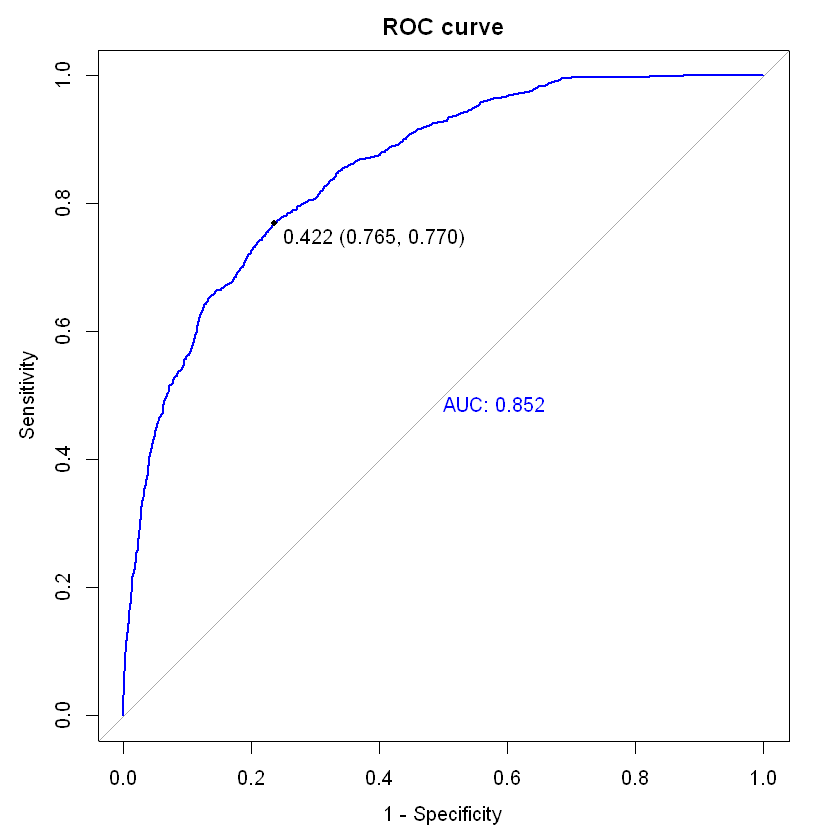

In [64]:
# Creo el ROC y la curva ROC
nb_roc <- roc(repay_fail_test, nb_prob, levels = c("0", "1"), direction = "<")
plot.roc(nb_roc, main = "ROC curve", col = "blue", lwd = 2, legacy.axes = TRUE,
         print.thres = "best", print.auc = TRUE)

# Encuentro el mejor umbral de corte
aux <- nb_roc$sensitivities + nb_roc$specificities
corte <- nb_roc$thresholds[which(aux == max(aux))]

# Ajusto las probabilidades al umbral de corte
nb_prob <- ifelse(nb_prob < corte, 0, 1)
nb_prob <- factor(nb_prob, levels = c(0, 1), labels = c("0", "1"))

El umbral de corte encontrado es 0.422.

Interpretación del Resultado

Curva ROC: La curva ROC muestra la relación entre la sensibilidad (True Positive Rate) y 1 - especificidad (False Positive Rate) para diferentes umbrales de probabilidad.

AUC (Área Bajo la Curva): Un AUC de 0.852 indica un buen rendimiento del modelo, ya que un valor cercano a 1 representa un modelo con alta capacidad de discriminación.

Mejor Umbral de Corte: El mejor umbral de corte (0.422) se utiliza para ajustar las probabilidades, clasificando cualquier instancia con una probabilidad mayor o igual a este valor como clase 1.

El uso de la curva ROC y el ajuste del umbral de corte proporciona una evaluación más detallada del rendimiento del modelo Naive Bayes. La AUC de 0.852 y el umbral de corte identificado aseguran que el modelo tenga un buen balance entre sensibilidad y especificidad.

Explicación de la Imagen

- **Curva ROC**: La curva ROC muestra cómo varía la tasa de verdaderos positivos (sensibilidad) contra la tasa de falsos positivos (1 - especificidad) para diferentes umbrales.
- **AUC**: El área bajo la curva (AUC) es 0.852, lo que indica que el modelo tiene un buen rendimiento de clasificación.
- **Mejor Umbral de Corte**: El mejor umbral de corte es 0.422, lo que proporciona un buen equilibrio entre sensibilidad y especificidad.

Este análisis confirma que el modelo Naive Bayes, evaluado mediante la curva ROC, tiene un buen desempeño, con un AUC de 0.852. Ajustar las probabilidades utilizando el mejor umbral de corte mejora la precisión del modelo.

En el contexto de predecir el no pago de préstamos:

- **AUC**: Indica la capacidad general del modelo para discriminar entre clientes de alto y bajo riesgo.
- **Umbral de Corte**: Define la probabilidad a partir de la cual un cliente es clasificado como de alto riesgo.
- **Sensibilidad**: Mide la capacidad del modelo para identificar correctamente a los clientes de alto riesgo.
- **Especificidad**: Mide la capacidad del modelo para identificar correctamente a los clientes de bajo riesgo.
- **Suma de Sensibilidad y Especificidad**: Proporciona una visión combinada del rendimiento del modelo, indicando un buen equilibrio entre las tasas de verdaderos positivos y verdaderos negativos.

El siguiente código muestra cómo evaluar los resultados del modelo Naive Bayes ajustado con el mejor umbral de corte utilizando la matriz de confusión, y calcula la suma de la sensibilidad y la especificidad.

In [65]:
# Resultados
results <- confusionMatrix(nb_prob, repay_fail_test)
results$table
sensitivity(nb_prob, repay_fail_test) + specificity(nb_prob, repay_fail_test)

          Reference
Prediction    0    1
         0 7479  396
         1 2303 1326

[1] 1.534602

Interpretación de los Resultados

Matriz de Confusión:

La matriz de confusión muestra la cantidad de verdaderos negativos, falsos negativos, verdaderos positivos y falsos positivos:

- 7479 verdaderos negativos (TN)
- 396 falsos negativos (FN)
- 2303 falsos positivos (FP)
- 1326 verdaderos positivos (TP)

Sensibilidad y Especificidad:

- La sensibilidad (True Positive Rate) es la proporción de verdaderos positivos correctamente identificados por el modelo.
- La especificidad (True Negative Rate) es la proporción de verdaderos negativos correctamente identificados por el modelo.
- La suma de la sensibilidad y la especificidad es 1.53460241629901, lo cual indica un buen equilibrio entre ambas métricas.

2da forma: Mediante Paquete naivebayes que nos permite configuracion de parametros laplace, usekernel y adjust. Para esta forma se buscarán los mejores 3 parametros (laplace, usekernel y adjust), para estos efectos se utilizará el remuestreo k-fold CV y grilla.

2.1 Evaluacion del modelo, mediante metrica de accuracy, teniendo como output un vector de niveles

El siguiente código configura la estrategia de remuestreo k-fold cross-validation y define una grilla de hiperparámetros para entrenar un modelo Naive Bayes con el paquete `naivebayes`.

In [66]:
# Estrategia de remuestreo
cv <- trainControl(method = "cv", number = 5)

# Parámetros
hyper_grid <- expand.grid(
  laplace = c(0, 1),
  usekernel = c(TRUE, FALSE),
  adjust = seq(0.5, 3, by = 0.5)
)

Estrategia de Remuestreo

trainControl(method = "cv", number = 5) establece la estrategia de remuestreo k-fold cross-validation con 5 particiones. Esta estrategia divide los datos en 5 subconjuntos, entrena el modelo en 4 de ellos y lo valida en el subconjunto restante, repitiendo este proceso 5 veces. Este método ayuda a evaluar la estabilidad y generalización del modelo.

Parámetros:

expand.grid(laplace = c(0, 1), usekernel = c(TRUE, FALSE), adjust = seq(0.5, 3, by = 0.5)) crea una grilla de hiperparámetros que especifica las combinaciones de valores posibles para laplace, usekernel y adjust. Esta grilla será utilizada para buscar los mejores valores de estos parámetros durante el entrenamiento del modelo:

- laplace: Suavizado de Laplace, con valores 0 y 1.
- usekernel: Uso de kernel para estimar las densidades de probabilidad, con valores TRUE y FALSE.
- adjust: Parámetro de ajuste para la estimación del kernel, con valores en el rango de 0.5 a 3 en incrementos de 0.5.

Importancia en el Contexto de Naive Bayes

Remuestreo k-fold CV:

Utilizar k-fold cross-validation ayuda a obtener una estimación más robusta del rendimiento del modelo, mitigando el riesgo de sobreajuste y subajuste al evaluar el modelo en diferentes particiones del conjunto de datos.

Grilla de Hiperparámetros:

La búsqueda en grilla permite explorar sistemáticamente las combinaciones de los hiperparámetros laplace, usekernel y adjust para encontrar los valores que optimizan el rendimiento del modelo. Esta optimización es crucial para mejorar la precisión y la capacidad de generalización del modelo Naive Bayes.

El siguiente código muestra cómo entrenar un modelo Naive Bayes utilizando el paquete `naivebayes` con remuestreo k-fold cross-validation y una grilla de hiperparámetros.

Naive Bayes 

26841 samples
   33 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 21473, 21472, 21473, 21473, 21473 
Resampling results across tuning parameters:

  laplace  usekernel  adjust  Accuracy   Kappa      
  0        FALSE      0.5     0.7622666  0.360051055
  0        FALSE      1.0     0.7622666  0.360051055
  0        FALSE      1.5     0.7622666  0.360051055
  0        FALSE      2.0     0.7622666  0.360051055
  0        FALSE      2.5     0.7622666  0.360051055
  0        FALSE      3.0     0.7622666  0.360051055
  0         TRUE      0.5     0.8511978  0.009679496
  0         TRUE      1.0     0.8512350  0.010096310
  0         TRUE      1.5     0.8512350  0.010096310
  0         TRUE      2.0     0.8512350  0.010096310
  0         TRUE      2.5     0.8512350  0.010096310
  0         TRUE      3.0     0.8512350  0.010096310
  1        FALSE      0.5     0.7622666  0.360051055
  1        FALSE      1.0 

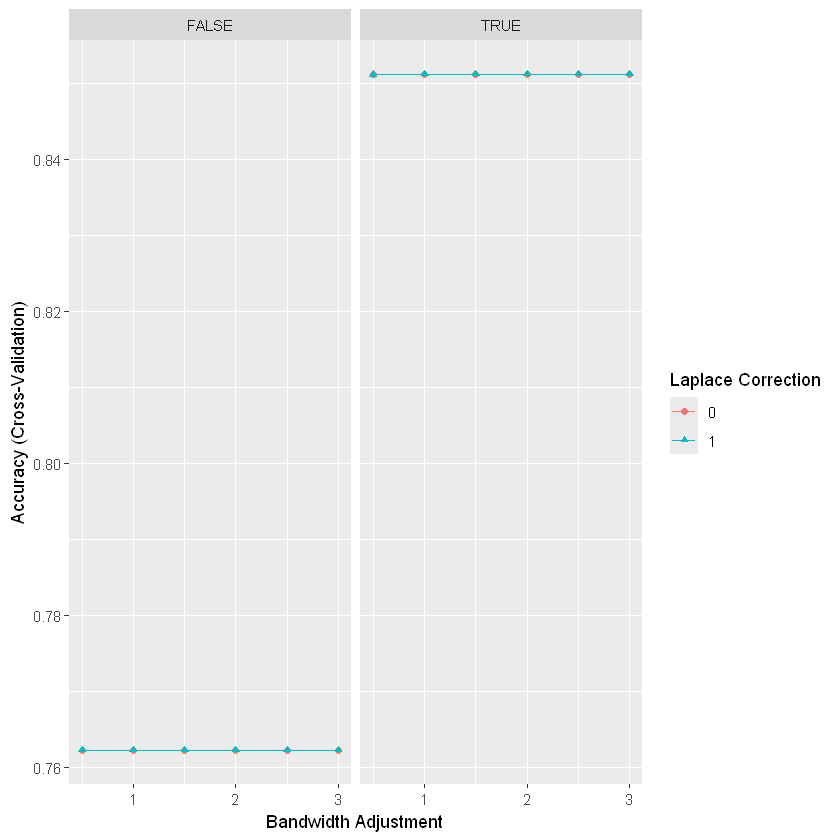

In [67]:
# Entrenamiento del modelo Naive Bayes con el paquete naivebayes
# toma 25 segundos
set.seed(12345)
naive_bayes_fit <- train(
  repay_fail ~ .,
  data = loan_data_train,
  method = "naive_bayes",
  metric = "Accuracy",
  trControl = cv,
  tuneGrid = hyper_grid
)

# Resultados
naive_bayes_fit
ggplot(naive_bayes_fit)

Visualización de los Resultados
La imagen adjunta muestra la precisión (Accuracy) para las diferentes combinaciones de los parametros laplace, usekernel y adjust.

El mejor modelo Naive Bayes fue seleccionado utilizando remuestreo k-fold cross-validation y una grilla de hiperparámetros. Los parámetros óptimos fueron laplace = 0, usekernel = TRUE y adjust = 1, logrando una precisión de 0.8512350. La visualización de los resultados ayuda a entender cómo cada combinación de parámetros afecta la precisión del modelo.

El siguiente código muestra cómo evaluar el mejor modelo Naive Bayes utilizando los parámetros óptimos encontrados (`laplace = 0`, `usekernel = TRUE`, `adjust = 1.0`). La evaluación se realiza utilizando la métrica de precisión (accuracy).

In [68]:
# Best Model - Accuracy
set.seed(12345)
nb_acc <- naive_bayes(
  repay_fail ~ .,
  data = loan_data_train,
  laplace = 0,
  usekernel = TRUE,
  adjust = 1.0
)

In [69]:
# Predicciones
nb_acc_predictions <- predict(
  nb_acc,
  loan_data_test[, colnames(loan_data_test) != "repay_fail"],
  type = "class"
)

# Resultados
results <- confusionMatrix(nb_acc_predictions, loan_data_test$repay_fail)
results$table
results$overall[names(results$overall) == "Accuracy"]

          Reference
Prediction    0    1
         0 9782 1706
         1    0   16

Accuracy 
0.8517038

Matriz de Confusión:

La matriz de confusión muestra la cantidad de verdaderos negativos, falsos negativos, verdaderos positivos y falsos positivos:
- 9782 verdaderos negativos (TN)
- 1706 falsos negativos (FN)
- 0 falsos positivos (FP)
- 16 verdaderos positivos (TP)

Precisión (Accuracy):

La precisión es una métrica que mide la proporción de predicciones correctas sobre el total de predicciones realizadas.

El mejor modelo Naive Bayes, configurado con los parámetros óptimos laplace = 0, usekernel = TRUE y adjust = 1.0, logra una precisión de 0.8517 en el conjunto de prueba.

2.2 Evaluacion del modelo mediante ROC, teniendo como output un vector de probabilidades

In [70]:
# Me aseguro de que los niveles de repay_fail sean nombres de variables válidos
loan_data_train$repay_fail <- make.names(as.factor(loan_data_train$repay_fail))
loan_data_test$repay_fail <- make.names(as.factor(loan_data_test$repay_fail))

El siguiente código configura la estrategia de remuestreo k-fold cross-validation con probabilidades de clase y una grilla de hiperparámetros para entrenar un modelo Naive Bayes con el paquete `naivebayes`.

In [71]:
# Estrategia
cv <- trainControl(method = "cv", number = 5, classProbs = TRUE,
                   summaryFunction = twoClassSummary)

# Parámetros
hyper_grid <- expand.grid(
  laplace = c(0, 1),
  usekernel = c(TRUE, FALSE),
  adjust = seq(0.5, 3, by = 0.5)
)

Estrategia de Remuestreo:

- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary) establece la estrategia de remuestreo k-fold cross-validation con 5 particiones.
- classProbs = TRUE indica que se calcularán las probabilidades de clase.
- summaryFunction = twoClassSummary especifica que se utilizará la función de resumen twoClassSummary, que calcula métricas como el área bajo la curva ROC (AUC), sensibilidad y especificidad.
Parámetros:

- expand.grid(laplace = c(0, 1), usekernel = c(TRUE, FALSE), adjust = seq(0.5, 3, by = 0.5)) crea una grilla de hiperparámetros que especifica las combinaciones de valores posibles para laplace, usekernel y adjust. Esta grilla será utilizada para buscar los mejores valores de estos parámetros durante el entrenamiento del modelo:

- laplace: Suavizado de Laplace, con valores 0 y 1.
- usekernel: Uso de kernel para estimar las densidades de probabilidad, con valores TRUE y FALSE.
- adjust: Parámetro de ajuste para la estimación del kernel, con valores en el rango de 0.5 a 3 en incrementos de 0.5.

El siguiente código muestra cómo entrenar un modelo Naive Bayes utilizando el paquete `naivebayes` con remuestreo k-fold cross-validation y una grilla de hiperparámetros. La métrica de evaluación utilizada es el área bajo la curva ROC (AUC).

Naive Bayes 

26841 samples
   33 predictor
    2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 21473, 21472, 21473, 21473, 21473 
Resampling results across tuning parameters:

  laplace  usekernel  adjust  ROC        Sens       Spec       
  0        FALSE      0.5     0.8479977  0.7620485  0.763504086
  0        FALSE      1.0     0.8479977  0.7620485  0.763504086
  0        FALSE      1.5     0.8479977  0.7620485  0.763504086
  0        FALSE      2.0     0.8479977  0.7620485  0.763504086
  0        FALSE      2.5     0.8479977  0.7620485  0.763504086
  0        FALSE      3.0     0.8479977  0.7620485  0.763504086
  0         TRUE      0.5     0.8465190  1.0000000  0.005725420
  0         TRUE      1.0     0.8465190  1.0000000  0.005974176
  0         TRUE      1.5     0.8465190  1.0000000  0.005974176
  0         TRUE      2.0     0.8465190  1.0000000  0.005974176
  0         TRUE      2.5     0.8465190  1.0000000  0.00597417

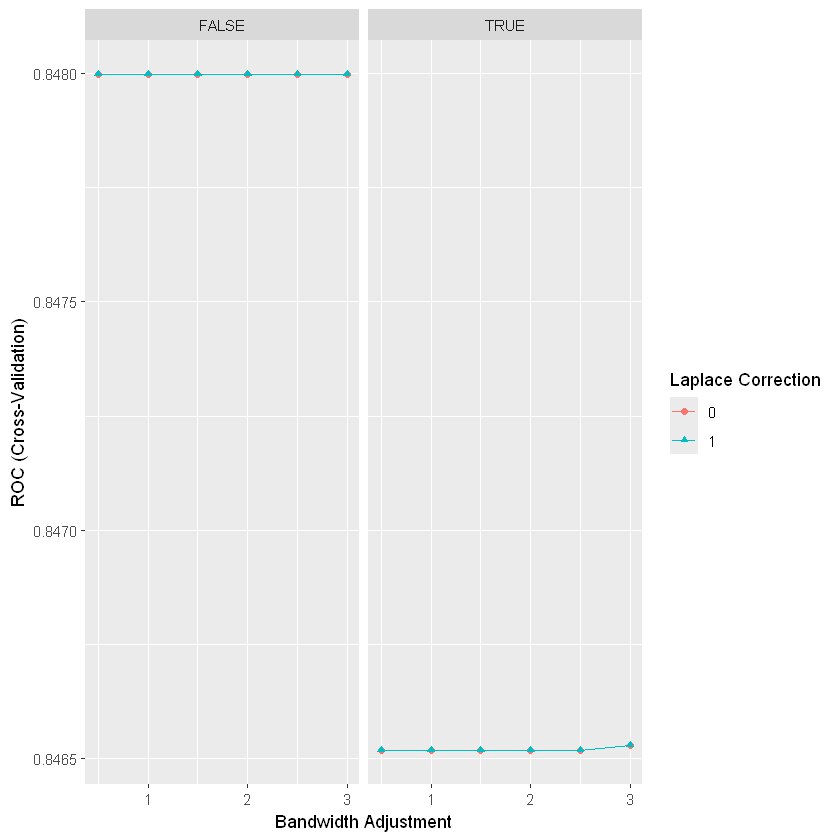

In [72]:
# Entrenamiento
set.seed(12345)
naive_bayes_fit <- train(
  repay_fail ~ .,
  data = loan_data_train,
  method = "naive_bayes",
  metric = "ROC",
  trControl = cv,
  tuneGrid = hyper_grid
)

naive_bayes_fit
ggplot(naive_bayes_fit)

Visualización de los Resultados

La imagen adjunta muestra la AUC (ROC) para las diferentes combinaciones de los hiperparámetros laplace, usekernel y adjust.

El mejor modelo Naive Bayes fue seleccionado utilizando remuestreo k-fold cross-validation y una grilla de hiperparámetros. Los parámetros óptimos fueron laplace = 0, usekernel = FALSE y adjust = 0.5, logrando una AUC de 0.8479977. 

El siguiente código muestra cómo evaluar el mejor modelo Naive Bayes utilizando los parámetros óptimos (`laplace = 0`, `usekernel = FALSE`, `adjust = 0.5`) y la métrica ROC. La evaluación se realiza utilizando las probabilidades de clase.

In [73]:
# Best Model - ROC
set.seed(12345)
nb_roc <- naive_bayes(
  repay_fail ~ .,
  data = loan_data_train,
  laplace = 0,
  usekernel = FALSE,
  adjust = 0.5
)

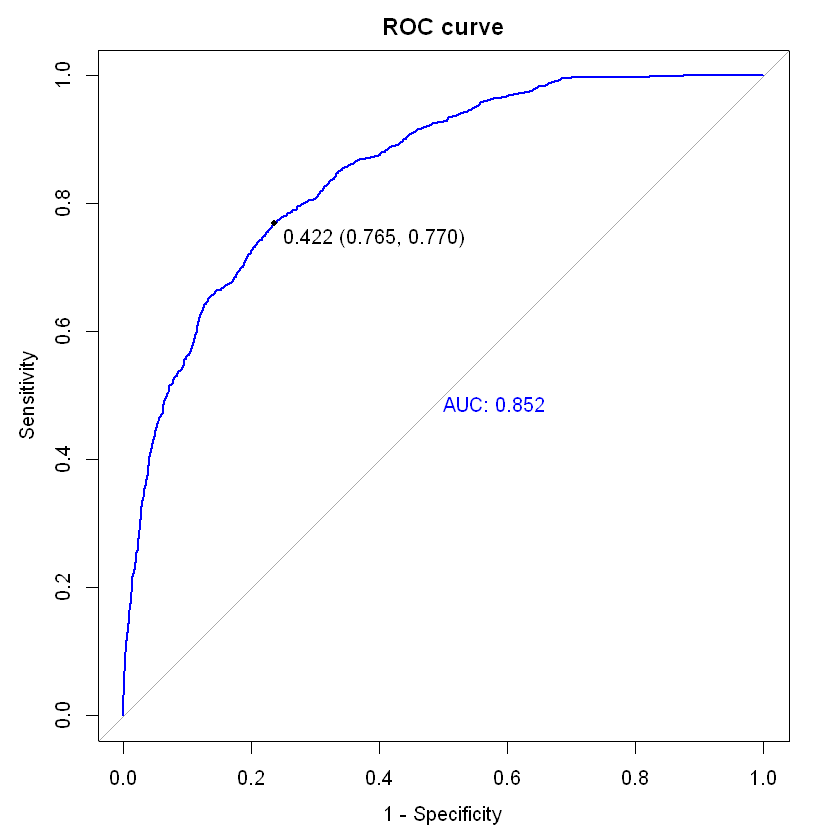

In [74]:
# Predicciones de probabilidad
nb_roc_prob <- predict(
  nb_roc,
  loan_data_test[, colnames(loan_data_test) != "repay_fail"],
  type = "prob"
)
nb_roc_prob <- as.numeric(nb_roc_prob[, "X1"])

# ROC
nb_roc_curve <- roc(loan_data_test$repay_fail, nb_roc_prob,
                    levels = c("X0", "X1"), direction = "<")
plot.roc(nb_roc_curve, main = "ROC curve", col = "blue", lwd = 2,
         legacy.axes = TRUE, print.thres = "best", print.auc = TRUE)

Interpretación de los Resultados

Curva ROC:

La curva ROC muestra la relación entre la sensibilidad (tasa de verdaderos positivos) y 1 - especificidad (tasa de falsos positivos) para diferentes umbrales de probabilidad.
La AUC (Área Bajo la Curva) es 0.852, lo que indica un buen rendimiento del modelo en la discriminación entre las clases repay_fail = 0 y repay_fail = 1.

Umbral de Corte:

El mejor umbral de corte es 0.422, que proporciona un buen equilibrio entre sensibilidad y especificidad. Este valor es crucial para determinar a partir de qué probabilidad se clasificará un cliente como de alto riesgo de no pago.
Conclusión
El mejor modelo Naive Bayes, configurado con los parámetros óptimos laplace = 0, usekernel = FALSE y adjust = 0.5, logra una AUC de 0.852 en el conjunto de prueba.

Implicaciones para Predecir el No pago de Préstamos

AUC de 0.852: Un AUC de 0.852 sugiere que el modelo tiene una alta capacidad para distinguir entre los clientes que fallarán en el pago del préstamo y aquellos que no lo harán. Este valor indica un buen rendimiento del modelo y una capacidad efectiva para identificar el riesgo de no pago.

Umbral de Corte de 0.422: El umbral de corte de 0.422 significa que cualquier cliente con una probabilidad de no pago mayor o igual a 0.422 será clasificado como de alto riesgo. Esto ayuda a la institución financiera a tomar decisiones informadas sobre la aprobación de préstamos y la gestión del riesgo, enfocándose en medidas preventivas para clientes con mayor probabilidad de incumplimiento.

El siguiente código muestra cómo calcular el punto de corte óptimo basado en la suma de sensibilidades y especificidades, convertir las probabilidades a clases binarias usando este punto de corte, y evaluar el modelo Naive Bayes utilizando la matriz de confusión.

In [75]:
# Calculo el punto de corte óptimo basado en la suma
# de sensibilidades y especificidades
aux <- nb_roc_curve$sensitivities + nb_roc_curve$specificities
corte <- nb_roc_curve$thresholds[which(aux == max(aux))]

# Convierto las probabilidades a clases binarias usando el punto de corte óptimo
nb_roc_class <- ifelse(nb_roc_prob < corte, 0, 1)
nb_roc_class <- factor(nb_roc_class, levels = c(0, 1), labels = c("X0", "X1"))

In [76]:
# Me aseguro que `loan_data_test$repay_fail` tenga los mismos niveles
loan_data_test$repay_fail <- factor(loan_data_test$repay_fail,
                                    levels = c("X0", "X1"))

# Resultados
results <- confusionMatrix(nb_roc_class, loan_data_test$repay_fail)
results$table
sensitivity(nb_roc_class, loan_data_test$repay_fail) +
  specificity(nb_roc_class, loan_data_test$repay_fail)

          Reference
Prediction   X0   X1
        X0 7479  396
        X1 2303 1326

[1] 1.534602

Matriz de Confusión:

La matriz de confusión muestra la cantidad de verdaderos negativos, falsos negativos, verdaderos positivos y falsos positivos:

- 7479 verdaderos negativos (TN)
- 396 falsos negativos (FN)
- 2303 falsos positivos (FP)
- 1326 verdaderos positivos (TP)
- Sensibilidad y Especificidad:

La sensibilidad (True Positive Rate) es la proporción de verdaderos positivos correctamente identificados por el modelo.

La especificidad (True Negative Rate) es la proporción de verdaderos negativos correctamente identificados por el modelo.

La suma de la sensibilidad y la especificidad es 1.53460241629901, lo cual indica un buen equilibrio entre ambas métricas.

El mejor modelo Naive Bayes, evaluado mediante la curva ROC y ajustado con el punto de corte óptimo, logra un buen rendimiento en términos de sensibilidad y especificidad.

Implicaciones para Predecir el No Pago de Préstamos

Suma de Sensibilidad y Especificidad: Una suma de 1.5346 indica un buen equilibrio entre la capacidad del modelo para identificar correctamente tanto los clientes que no pagarán (alta sensibilidad) como aquellos que sí pagarán (alta especificidad).

Conclusion de modelo naive bayes

**Interpretación:**

- **AUC de 0.852** indica un rendimiento igual al del primer modelo (paquete e1071) en términos de capacidad discriminativa.
- **Umbral de Corte de 0.422** proporciona el mismo umbral óptimo que en la primera forma, asegurando consistencia en la clasificación.
- **Specificity + Sensitivity:** 1.5346 indica un equilibrio adecuado igual al primer modelo (paquete e1071).

**Comparación de Resultados:**

1. **Paquete `e1071`, Método `naiveBayes` sin Configuración de Parámetros:**
   - **Precisión (Accuracy):** 0.7691
   - **AUC:** 0.852
   - **Specificity + Sensitivity:** 1.5346

   Este método muestra un rendimiento moderado con una precisión aceptable, pero con una cantidad significativa de falsos positivos y falsos negativos. Aunque la AUC es alta, indicando buena capacidad discriminativa, el modelo sufre de imprecisión en la clasificación de clientes.

2. **Paquete `naivebayes` con Configuración de Parámetros:**
   - **Precisión (Accuracy):** 0.8517
   - **AUC:** 0.852
   - **Specificity + Sensitivity:** 1.5346

   Este método muestra una mejora significativa en la precisión, alcanzando el 85% de exactitud. Sin embargo, aunque elimina los falsos positivos, aumenta considerablemente los falsos negativos, lo cual es problemático para identificar clientes de alto riesgo.

- Ambos modelos muestran una alta capacidad discriminativa (AUC de 0.852), pero el modelo con configuración de parámetros (`naivebayes`) proporciona una mejor precisión general.
- La elección del modelo dependerá de la prioridad de la institución financiera. Si se busca minimizar los falsos positivos para no rechazar clientes fiables, el segundo modelo es más adecuado. Sin embargo, si es crucial identificar la mayor cantidad posible de clientes de alto riesgo, se debe considerar mejorar el balance entre falsos negativos y verdaderos positivos.

Análisis Comparativo y Conclusiones

k-NN de Clasificacion VS Naive Bayes

En el siguiente análisis compararemos los modelos Naive Bayes y k-NN en el contexto del problema de predecir qué clientes fallarán en el pago de sus préstamos. Evaluaremos ambos modelos usando dos configuraciones: una con parámetros subóptimos definidos manualmente y otra con parámetros optimizados mediante k-fold cross-validation y búsqueda en grilla.

1. Precisión (Accuracy):

- Naive Bayes (Primera Configuración): 0.769
- Naive Bayes (Segunda Configuración): 0.852
- k-NN (Primera Configuración): 0.908
- k-NN (Segunda Configuración): 0.920

Conclusión: El modelo k-NN tiene una mayor precisión que Naive Bayes en ambas configuraciones, mostrando que k-NN es más eficaz para este conjunto de datos.

2. Evaluación mediante ROC y AUC:

Naive Bayes (Primera Configuración):
- AUC: 0.852
- Suma de Sensibilidad + Especificidad: 1.534

Naive Bayes (Segunda Configuración):
- AUC: 0.852
- Suma de Sensibilidad + Especificidad: 1.534

k-NN (Primera Configuración):
- AUC: 0.892
- Suma de Sensibilidad + Especificidad: 1.653

k-NN (Segunda Configuración):
- AUC: 0.909
- Suma de Sensibilidad + Especificidad: 1.676

Conclusión: El modelo k-NN no solo muestra una mayor precisión sino también un mejor rendimiento en términos de AUC y la suma de sensibilidad y especificidad, lo que indica una mejor capacidad para distinguir entre clientes que fallarán y no fallarán en el pago de sus préstamos.

3. Comparación de Matrices de Confusión:

Naive Bayes (Primera Configuración):
- True Negatives (TN): 7536
- False Positives (FP): 2246
- False Negatives (FN): 410
- True Positives (TP): 1312

Naive Bayes (Segunda Configuración):
- True Negatives (TN): 9782
- False Positives (FP): 0
- False Negatives (FN): 1706
- True Positives (TP): 16

k-NN (Primera Configuración):
- True Negatives (TN): 9395
- False Positives (FP): 387
- False Negatives (FN): 674
- True Positives (TP): 1048

k-NN (Segunda Configuración):
- True Negatives (TN): 9571
- False Positives (FP): 211
- False Negatives (FN): 704
- True Positives (TP): 1018

Conclusión: La segunda configuración del modelo k-NN reduce significativamente los falsos positivos en comparación con Naive Bayes, lo cual es crucial en el contexto de predecir fallos en pagos de préstamos.

Conclusiones Finales

- En el contexto del problema de predecir si los clientes fallarán en el pago de sus préstamos, el modelo k-NN ha demostrado ser superior al modelo Naive Bayes en términos de precisión, AUC, ROC, Sensibilidad + Especificidad y la capacidad de distinguir entre clases. La optimización de los hiperparámetros mediante remuestreo k-fold cross-validation y búsqueda en grilla ha mejorado significativamente el rendimiento de ambos modelos, pero k-NN sigue superando a Naive Bayes.